# Imports


In [1]:
import os
import pandas as pd
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import warnings
pd.set_option('display.max_columns', None)
# Suppress Matplotlib warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# Load Data
- [Merge Admin Data with Diagnosis Data](#Merge-Admin-Data-with-Diagnosis-Data)
- [Rules](#Rules)
- [Chart Events](#Chart-Events)
- [Encoding](#Encoding)
- [Model Building](#Model-Building)
- [EDA](#EDA)



In [2]:
admissions = pd.read_csv('Data/admissions.csv')
d_icd_diagnoses = pd.read_csv('Data/d_icd_diagnoses.csv')
diagnoses_icd = pd.read_csv('Data/diagnoses_icd.csv')
patients = pd.read_csv('Data/patients.csv')
re_chart_events = pd.read_csv('Data/re_chart_events.csv')

print(admissions.shape, 'admissions')
display(admissions.head())
print(d_icd_diagnoses.shape, 'd_icd_diagnoses')
display(d_icd_diagnoses.head())
print(diagnoses_icd.shape, 'd_items_data')
display(diagnoses_icd.head())
print(patients.shape, 'patients')
display(patients.head())
print(re_chart_events.shape, 're_chart_events')
display(re_chart_events.head())

(431231, 16) admissions


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


(109775, 3) d_icd_diagnoses


,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


(4756326, 5) d_items_data


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


(299712, 6) patients


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


(134354, 14) re_chart_events


,Unnamed: 0,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,max_chart_time
0,0,12633892,26749242,35517603,74261.0,2114-09-28 09:00:00,2114-09-28 09:14:00,220210,21,21.0,insp/min,0,Respiratory Rate,2114-09-28 09:00:00
1,1,16751019,28171969,37725857,64542.0,2125-11-07 16:00:00,2125-11-07 16:35:00,220180,61,61.0,mmHg,0,Non Invasive Blood Pressure diastolic,2125-11-07 16:00:00
2,2,13028012,23471437,30044052,46303.0,2138-11-09 17:00:00,2138-11-09 17:21:00,220045,103,103.0,bpm,0,Heart Rate,2138-11-09 17:00:00
3,3,12988457,25880850,37601939,34043.0,2156-02-18 21:01:00,2156-02-18 21:06:00,220180,72,72.0,mmHg,0,Non Invasive Blood Pressure diastolic,2156-02-18 21:01:00
4,4,13804408,26908606,31508846,83437.0,2124-04-28 05:00:00,2124-04-28 04:53:00,220181,97,97.0,mmHg,0,Non Invasive Blood Pressure mean,2124-04-28 05:00:00


### Database connection ChartEvents

### Merge Diagnosis Data with Diagnosis Code(ICD)

In [3]:
## Merge Diagnosis Data with Diagnosis Code(ICD)
diagnosis_data = pd.merge(diagnoses_icd, d_icd_diagnoses, on=['icd_code','icd_version'], how='left')
pat_diagn_data = pd.merge(diagnosis_data, patients, on='subject_id', how='left')

print(pat_diagn_data.shape, 'diagnosis_data')
pat_diagn_data.tail()

(4756326, 11) diagnosis_data


,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,gender,anchor_age,anchor_year,anchor_year_group,dod
4756321,19999987,23865745,7,41401,9,Coronary atherosclerosis of native coronary ar...,F,57,2145,2011 - 2013,NaN
4756322,19999987,23865745,8,78039,9,Other convulsions,F,57,2145,2011 - 2013,NaN
4756323,19999987,23865745,9,0413,9,Friedländer's bacillus infection in conditions...,F,57,2145,2011 - 2013,NaN
4756324,19999987,23865745,10,36846,9,Homonymous bilateral field defects,F,57,2145,2011 - 2013,NaN
4756325,19999987,23865745,11,7810,9,Abnormal involuntary movements,F,57,2145,2011 - 2013,NaN


In [4]:
pat_diagn_data['icd'] = pat_diagn_data.icd_code.str[:3]
pat_diagn_data.tail()

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,gender,anchor_age,anchor_year,anchor_year_group,dod,icd
4756321,19999987,23865745,7,41401,9,Coronary atherosclerosis of native coronary ar...,F,57,2145,2011 - 2013,NaN,414
4756322,19999987,23865745,8,78039,9,Other convulsions,F,57,2145,2011 - 2013,NaN,780
4756323,19999987,23865745,9,0413,9,Friedländer's bacillus infection in conditions...,F,57,2145,2011 - 2013,NaN,041
4756324,19999987,23865745,10,36846,9,Homonymous bilateral field defects,F,57,2145,2011 - 2013,NaN,368
4756325,19999987,23865745,11,7810,9,Abnormal involuntary movements,F,57,2145,2011 - 2013,NaN,781


### ICD CODES

- 001–139: infectious and parasitic diseases
- 140–239: neoplasms
- 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
- 280–289: diseases of the blood and blood-forming organs
- 290–319: mental disorders
- 320–389: diseases of the nervous system and sense organs
- 390–459: diseases of the circulatory system
- 460–519: diseases of the respiratory system
- 520–579: diseases of the digestive system
- 580–629: diseases of the genitourinary system
- 630–679: complications of pregnancy, childbirth, and the puerperium
- 680–709: diseases of the skin and subcutaneous tissue
- 710–739: diseases of the musculoskeletal system and connective tissue
- 740–759: congenital anomalies
- 760–779: certain conditions originating in the perinatal period
- 780–799: symptoms, signs, and ill-defined conditions
- 800–999: injury and poisoning
- E and V codes: external causes of injury and supplemental classification


***Chapter	Block	Title***
- https://www.icd10data.com/ICD10CM/Codes
- I	A00–B99	Certain infectious and parasitic diseases
- II	C00–D48	Neoplasms
- III	D50–D89	Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism
- IV	E00–E90	Endocrine, nutritional and metabolic diseases
- V	F00–F99	Mental and behavioural disorders
- VI	G00–G99	Diseases of the nervous system
- VII	H00–H59	Diseases of the eye and adnexa
- VIII	H60–H95	Diseases of the ear and mastoid process
- IX	I00–I99	Diseases of the circulatory system
- X	J00–J99	Diseases of the respiratory system
- XI	K00–K93	Diseases of the digestive system
- XII	L00–L99	Diseases of the skin and subcutaneous tissue
- XIII	M00–M99	Diseases of the musculoskeletal system and connective tissue
- XIV	N00–N99	Diseases of the genitourinary system
- XV	O00–O99	Pregnancy, childbirth and the puerperium
- XVI	P00–P96	Certain conditions originating in the perinatal period
- XVII	Q00–Q99	Congenital malformations, deformations and chromosomal abnormalities
- XVIII	R00–R99	Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified
- XIX	S00–T98	Injury, poisoning and certain other consequences of external causes
- XX	V01–Y98	External causes of morbidity and mortality
- XXI	Z00–Z99	Factors influencing health status and contact with health services
- XXII	U00–U99	Codes for special purposes

#### Mapping of ICD Codes

In [5]:

# Function to categorize ICD codes
def categorize_icd(icd):
    try:
        if 1 <= int(icd) <= 139:
            return 'Infectious and Parasitic Diseases'
        elif 140 <= int(icd) <= 239:
            return 'Neoplasms'
        elif 240 <= int(icd) <= 279:
            return 'Endocrine, Nutritional, and Metabolic Diseases'
        elif 280 <= int(icd) <= 289:
            return 'Diseases of the Blood and Blood-forming Organs'
        elif 290 <= int(icd) <= 319:
            return 'Mental Disorders'
        elif 320 <= int(icd) <= 389:
            return 'Diseases of the Nervous System and Sense Organs'
        elif 390 <= int(icd) <= 459:
            return 'Diseases of the Circulatory System'
        elif 460 <= int(icd) <= 519:
            return 'Diseases of the Respiratory System'
        elif 520 <= int(icd) <= 579:
            return 'Diseases of the Digestive System'
        elif 580 <= int(icd) <= 629:
            return 'Diseases of the Genitourinary System'
        elif 630 <= int(icd) <= 679:
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif 680 <= int(icd) <= 709:
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif 710 <= int(icd) <= 739:
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif 740 <= int(icd) <= 759:
            return 'Congenital Anomalies'
        elif 760 <= int(icd) <= 779:
            return 'Certain Conditions Originating in the Perinatal Period'
        elif 780 <= int(icd) <= 799:
            return 'Symptoms, Signs, and Ill-defined Conditions'
        elif 800 <= int(icd) <= 999:
            return 'Injury and Poisoning'
        
    except ValueError:
        if icd[0] == 'A' or icd[0] == 'B':
            return 'Infectious and Parasitic Diseases'
        elif icd[0] == 'C':
            return 'Neoplasms'
        elif icd[0] == 'D':
            return 'Diseases of the Blood and Blood-forming Organs'
        elif icd[0] == 'E':
            return 'External causes of injury and supplemental classification'
        elif icd[0] == 'F':
            return 'Mental Disorders'
        elif icd[0] == 'G':
            return 'Diseases of the Nervous System and Sense Organs'
        elif icd[0] == 'H':
            return 'Diseases of the eye, adnexa and mastoid process'
        elif icd[0] == 'I':
            return 'Diseases of the Circulatory System'
        elif icd[0] == 'J':
            return 'Diseases of the Respiratory System'
        elif icd[0] == 'K':
            return 'Diseases of the Digestive System'
        elif icd[0] == 'L':
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif icd[0] == 'M':
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif icd[0] == 'N':
            return 'Diseases of the Genitourinary System'
        elif icd[0] == 'O':
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif icd[0] == 'P':
            return 'Certain Conditions Originating in the Perinatal Period'
        elif icd[0] == 'Q':
            return 'Congenital Anomalies'
        elif icd[0] == 'R':
            return 'Symptoms, Signs, and Ill-defined Conditions'
        elif icd[0] == 'S' or icd[0] == 'T' :
            return 'Injury and Poisoning'
        elif icd[0] == 'U':
            return 'Codes for special purposes'
        elif icd[0] in ['V', 'W', 'X' ,'Y']:
            return 'External causes of injury and supplemental classification'
        elif icd[0] == 'Z':
            return 'Factors influencing health status and contact with health services'
                
        
# Apply function to create a new column
pat_diagn_data['diagnosis'] = pat_diagn_data['icd'].apply(categorize_icd)
pat_diagn_data.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,gender,anchor_age,anchor_year,anchor_year_group,dod,icd,diagnosis
0,10000032,22595853,1,5723,9,Portal hypertension,F,52,2180,2014 - 2016,2180-09-09,572,Diseases of the Digestive System
1,10000032,22595853,2,78959,9,Other ascites,F,52,2180,2014 - 2016,2180-09-09,789,"Symptoms, Signs, and Ill-defined Conditions"
2,10000032,22595853,3,5715,9,Cirrhosis of liver without mention of alcohol,F,52,2180,2014 - 2016,2180-09-09,571,Diseases of the Digestive System
3,10000032,22595853,4,07070,9,Unspecified viral hepatitis C without hepatic ...,F,52,2180,2014 - 2016,2180-09-09,070,Infectious and Parasitic Diseases
4,10000032,22595853,5,496,9,"Chronic airway obstruction, not elsewhere clas...",F,52,2180,2014 - 2016,2180-09-09,496,Diseases of the Respiratory System


In [6]:
admissions[admissions.subject_id==10000032]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0


In [7]:
round(pat_diagn_data.diagnosis.value_counts(normalize=True)*100)

diagnosis
External causes of injury and supplemental classification             18.0
Diseases of the Circulatory System                                    16.0
Factors influencing health status and contact with health services     7.0
Symptoms, Signs, and Ill-defined Conditions                            7.0
Mental Disorders                                                       7.0
Endocrine, Nutritional, and Metabolic Diseases                         7.0
Diseases of the Digestive System                                       7.0
Diseases of the Genitourinary System                                   5.0
Diseases of the Nervous System and Sense Organs                        5.0
Diseases of the Musculoskeletal System and Connective Tissue           4.0
Diseases of the Respiratory System                                     4.0
Diseases of the Blood and Blood-forming Organs                         4.0
Injury and Poisoning                                                   4.0
Neoplasms      

In [8]:
pat_diagn_data.diagnosis.nunique()

20

In [9]:
pat_diagn_data[pat_diagn_data.diagnosis.isna()]

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,gender,anchor_age,anchor_year,anchor_year_group,dod,icd,diagnosis


## Merge Admin Data with Diagnosis Data
- [Load Data](#Load-Data)
- [Rules](#Rules)
- [Chart Events](#Chart-Events)
- [Encoding](#Encoding)
- [Model Building](#Model-Building)
- [EDA](#EDA)


#### Merge Admission Data with Diagnosis Data

In [10]:
## Merge Admission Data with Diagnosis Data
admin_diag = pd.merge(admissions, pat_diagn_data, on=['subject_id','hadm_id'], how='left')
print(admin_diag.shape, 'admin_diag')
admin_diag.head()

(4756705, 27) admin_diag


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,seq_num,icd_code,icd_version,long_title,gender,anchor_age,anchor_year,anchor_year_group,dod,icd,diagnosis
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,1.0,5723,9.0,Portal hypertension,F,52.0,2180.0,2014 - 2016,2180-09-09,572,Diseases of the Digestive System
1,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,2.0,78959,9.0,Other ascites,F,52.0,2180.0,2014 - 2016,2180-09-09,789,"Symptoms, Signs, and Ill-defined Conditions"
2,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,3.0,5715,9.0,Cirrhosis of liver without mention of alcohol,F,52.0,2180.0,2014 - 2016,2180-09-09,571,Diseases of the Digestive System
3,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,4.0,07070,9.0,Unspecified viral hepatitis C without hepatic ...,F,52.0,2180.0,2014 - 2016,2180-09-09,070,Infectious and Parasitic Diseases
4,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,5.0,496,9.0,"Chronic airway obstruction, not elsewhere clas...",F,52.0,2180.0,2014 - 2016,2180-09-09,496,Diseases of the Respiratory System


In [11]:
## Select the required Columns
admin_diag = admin_diag[['subject_id', 'hadm_id', 'admittime','admission_type','admission_location',
                         'discharge_location', 'insurance', 'language', 'marital_status', 'race','long_title',
                         'icd_code','gender', 'anchor_age', 'diagnosis']]
admin_diag

,subject_id,hadm_id,admittime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,long_title,icd_code,gender,anchor_age,diagnosis
0,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Portal hypertension,5723,F,52.0,Diseases of the Digestive System
1,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Other ascites,78959,F,52.0,"Symptoms, Signs, and Ill-defined Conditions"
2,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Cirrhosis of liver without mention of alcohol,5715,F,52.0,Diseases of the Digestive System
3,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Unspecified viral hepatitis C without hepatic ...,07070,F,52.0,Infectious and Parasitic Diseases
4,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,"Chronic airway obstruction, not elsewhere clas...",496,F,52.0,Diseases of the Respiratory System
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4756700,19999987,23865745,2145-11-02 21:38:00,EW EMER.,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,Coronary atherosclerosis of native coronary ar...,41401,F,57.0,Diseases of the Circulatory System
4756701,19999987,23865745,2145-11-02 21:38:00,EW EMER.,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,Other convulsions,78039,F,57.0,"Symptoms, Signs, and Ill-defined Conditions"
4756702,19999987,23865745,2145-11-02 21:38:00,EW EMER.,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,Friedländer's bacillus infection in conditions...,0413,F,57.0,Infectious and Parasitic Diseases
4756703,19999987,23865745,2145-11-02 21:38:00,EW EMER.,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,Homonymous bilateral field defects,36846,F,57.0,Diseases of the Nervous System and Sense Organs


In [12]:
admin_diag.shape

(4756705, 15)

In [13]:
admin_diag.head()

,subject_id,hadm_id,admittime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,long_title,icd_code,gender,anchor_age,diagnosis
0,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Portal hypertension,5723,F,52.0,Diseases of the Digestive System
1,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Other ascites,78959,F,52.0,"Symptoms, Signs, and Ill-defined Conditions"
2,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Cirrhosis of liver without mention of alcohol,5715,F,52.0,Diseases of the Digestive System
3,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Unspecified viral hepatitis C without hepatic ...,07070,F,52.0,Infectious and Parasitic Diseases
4,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,"Chronic airway obstruction, not elsewhere clas...",496,F,52.0,Diseases of the Respiratory System


In [14]:
## Convert Time to Date
admin_diag['admittime'] = pd.to_datetime(admin_diag['admittime'])
admin_diag['admitdate'] = admin_diag['admittime'].dt.date

# Sort Values on the admin time
admin_diag.sort_values(['subject_id', 'admittime'], inplace=True)

## Get the time difference
admin_diag['admitdate_diff'] = admin_diag.groupby('subject_id')['admittime'].diff()
admin_diag.head(40)

,subject_id,hadm_id,admittime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,long_title,icd_code,gender,anchor_age,diagnosis,admitdate,admitdate_diff
0,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Portal hypertension,5723,F,52.0,Diseases of the Digestive System,2180-05-06,NaT
1,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Other ascites,78959,F,52.0,"Symptoms, Signs, and Ill-defined Conditions",2180-05-06,0 days 00:00:00
2,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Cirrhosis of liver without mention of alcohol,5715,F,52.0,Diseases of the Digestive System,2180-05-06,0 days 00:00:00
3,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Unspecified viral hepatitis C without hepatic ...,07070,F,52.0,Infectious and Parasitic Diseases,2180-05-06,0 days 00:00:00
4,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,"Chronic airway obstruction, not elsewhere clas...",496,F,52.0,Diseases of the Respiratory System,2180-05-06,0 days 00:00:00
5,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,"Bipolar disorder, unspecified",29680,F,52.0,Mental Disorders,2180-05-06,0 days 00:00:00
6,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Posttraumatic stress disorder,30981,F,52.0,Mental Disorders,2180-05-06,0 days 00:00:00
7,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Personal history of tobacco use,V1582,F,52.0,External causes of injury and supplemental cla...,2180-05-06,0 days 00:00:00
8,10000032,22841357,2180-06-26 18:27:00,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,Unspecified viral hepatitis C with hepatic coma,07071,F,52.0,Infectious and Parasitic Diseases,2180-06-26,50 days 20:04:00
9,10000032,22841357,2180-06-26 18:27:00,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,Other ascites,78959,F,52.0,"Symptoms, Signs, and Ill-defined Conditions",2180-06-26,0 days 00:00:00


In [15]:
# Replace 0s with NaN
admin_diag['admitdate_diff'] = admin_diag['admitdate_diff'].replace(pd.Timedelta(0), np.nan)

# Forward fill NaN values
admin_diag['admitdate_diff'] = admin_diag['admitdate_diff'].fillna(method='ffill')

admin_diag[['subject_id','hadm_id', 'admittime','admitdate_diff']].tail(20)

,subject_id,hadm_id,admittime,admitdate_diff
4756678,19999840,21033226,2164-09-10 13:47:00,47 days 13:20:00
4756679,19999840,21033226,2164-09-10 13:47:00,47 days 13:20:00
4756680,19999840,21033226,2164-09-10 13:47:00,47 days 13:20:00
4756681,19999840,21033226,2164-09-10 13:47:00,47 days 13:20:00
4756682,19999840,21033226,2164-09-10 13:47:00,47 days 13:20:00
4756683,19999840,21033226,2164-09-10 13:47:00,47 days 13:20:00
4756684,19999840,21033226,2164-09-10 13:47:00,47 days 13:20:00
4756685,19999840,21033226,2164-09-10 13:47:00,47 days 13:20:00
4756686,19999840,21033226,2164-09-10 13:47:00,47 days 13:20:00
4756694,19999987,23865745,2145-11-02 21:38:00,47 days 13:20:00


In [16]:
admin_diag[['subject_id', 'hadm_id', 'admittime',  'admitdate_diff']].head(40)

,subject_id,hadm_id,admittime,admitdate_diff
0,10000032,22595853,2180-05-06 22:23:00,NaT
1,10000032,22595853,2180-05-06 22:23:00,NaT
2,10000032,22595853,2180-05-06 22:23:00,NaT
3,10000032,22595853,2180-05-06 22:23:00,NaT
4,10000032,22595853,2180-05-06 22:23:00,NaT
5,10000032,22595853,2180-05-06 22:23:00,NaT
6,10000032,22595853,2180-05-06 22:23:00,NaT
7,10000032,22595853,2180-05-06 22:23:00,NaT
8,10000032,22841357,2180-06-26 18:27:00,50 days 20:04:00
9,10000032,22841357,2180-06-26 18:27:00,50 days 20:04:00


In [17]:
# Define boolean conditions for each range
admin_diag['<30'] = admin_diag['admitdate_diff'] <= pd.Timedelta(days=30)
admin_diag['<60'] = (admin_diag['admitdate_diff'] <= pd.Timedelta(days=60))
admin_diag['>365'] = admin_diag['admitdate_diff'] > pd.Timedelta(days=365)

# Convert boolean values to integers (0 and 1)
admin_diag['<30'] = admin_diag['<30'].astype(int)
admin_diag['<60'] = admin_diag['<60'].astype(int)
admin_diag['>365'] = admin_diag['>365'].astype(int)
## Convert to Days
admin_diag['admitdate_diff'] = admin_diag['admitdate_diff'].dt.days
admin_diag[['subject_id','hadm_id', 'admittime','admitdate_diff','<30','<60','>365']].head(40)

,subject_id,hadm_id,admittime,admitdate_diff,<30,<60,>365
0,10000032,22595853,2180-05-06 22:23:00,NaN,0,0,0
1,10000032,22595853,2180-05-06 22:23:00,NaN,0,0,0
2,10000032,22595853,2180-05-06 22:23:00,NaN,0,0,0
3,10000032,22595853,2180-05-06 22:23:00,NaN,0,0,0
4,10000032,22595853,2180-05-06 22:23:00,NaN,0,0,0
5,10000032,22595853,2180-05-06 22:23:00,NaN,0,0,0
6,10000032,22595853,2180-05-06 22:23:00,NaN,0,0,0
7,10000032,22595853,2180-05-06 22:23:00,NaN,0,0,0
8,10000032,22841357,2180-06-26 18:27:00,50.0,0,1,0
9,10000032,22841357,2180-06-26 18:27:00,50.0,0,1,0


In [18]:
admin_diag.shape

(4756705, 20)

## Rules
- [Load Data](#Load-Data)
- [Merge Admin Data with Diagnosis Data](#Merge-Admin-Data-with-Diagnosis-Data)
- [Chart Events](#Chart-Events)
- [Encoding](#Encoding)
- [Model Building](#Model-Building)
- [EDA](#EDA)


In [19]:
## Recategorize Admission Type
conditions = admin_diag['admission_type'].isin(['EW EMER.', 'URGENT', 'DIRECT EMER.'])
admin_diag['admission_type'] = np.where(conditions, 'Emergency', admin_diag['admission_type'])

conditions = admin_diag['admission_type'].isin(['OBSERVATION ADMIT', 'EU OBSERVATION', 'DIRECT OBSERVATION', 'AMBULATORY OBSERVATION'])
admin_diag['admission_type'] = np.where(conditions, 'Observation', admin_diag['admission_type'])

conditions = admin_diag['admission_type'].isin(['SURGICAL SAME DAY ADMISSION'])
admin_diag['admission_type'] = np.where(conditions, 'Surgical Same Day Admission', admin_diag['admission_type'])

conditions = admin_diag['admission_type'].isin(['ELECTIVE'])
admin_diag['admission_type'] = np.where(conditions, 'Elective', admin_diag['admission_type'])

print(admin_diag.shape)
admin_diag.head()

(4756705, 20)


,subject_id,hadm_id,admittime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,long_title,icd_code,gender,anchor_age,diagnosis,admitdate,admitdate_diff,<30,<60,>365
0,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Portal hypertension,5723,F,52.0,Diseases of the Digestive System,2180-05-06,NaN,0,0,0
1,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Other ascites,78959,F,52.0,"Symptoms, Signs, and Ill-defined Conditions",2180-05-06,NaN,0,0,0
2,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Cirrhosis of liver without mention of alcohol,5715,F,52.0,Diseases of the Digestive System,2180-05-06,NaN,0,0,0
3,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Unspecified viral hepatitis C without hepatic ...,07070,F,52.0,Infectious and Parasitic Diseases,2180-05-06,NaN,0,0,0
4,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,"Chronic airway obstruction, not elsewhere clas...",496,F,52.0,Diseases of the Respiratory System,2180-05-06,NaN,0,0,0


In [20]:
admin_diag.admission_type.value_counts()

admission_type
Emergency                      2701217
Observation                    1621007
Surgical Same Day Admission     314230
Elective                        120251
Name: count, dtype: int64

In [21]:
## Recategorize Race
admin_diag['race'] = np.where(admin_diag['race'].isin(['AMERICAN INDIAN/ALASKA NATIVE']), 'AMERICAN INDIAN/ALASKA NATIVE',
                            np.where(admin_diag['race'].isin(['ASIAN', 'ASIAN - ASIAN INDIAN', 'ASIAN - CHINESE',
                                                                           'ASIAN - KOREAN', 'ASIAN - SOUTH EAST ASIAN']),
                                     'ASIAN',
                            np.where(admin_diag['race'].isin(['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 
                                                                           'BLACK/CAPE VERDEAN', 'BLACK/CARIBBEAN ISLAND']),
                                     'BLACK/AFRICAN',
                            np.where(admin_diag['race'].isin(['HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN',
                                                                           'HISPANIC/LATINO - COLUMBIAN', 'HISPANIC/LATINO - CUBAN',
                                                                           'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN', 
                                                                           'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - MEXICAN', 
                                                                           'HISPANIC/LATINO - PUERTO RICAN','HISPANIC/LATINO - SALVADORAN']), 
                                     'HISPANIC OR LATINO',
                            np.where(admin_diag['race'].isin(['NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER']), 
                                     'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                            np.where(admin_diag['race'].isin(['MULTIPLE RACE/race', 'OTHER', 
                                                                      'PATIENT DECLINED TO ANSWER', 'UNABLE TO OBTAIN', 'UNKNOWN']), 
                                     'OTHER',
                            np.where(admin_diag['race'].isin(['PORTUGUESE']), 'PORTUGUESE',
                            np.where(admin_diag['race'].isin(['SOUTH AMERICAN']), 'SOUTH AMERICAN',
                            np.where(admin_diag['race'].isin(['WHITE', 'WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN',
                                                                           'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN']), 
                                     'WHITE',
                    np.nan)))))))))

round(admin_diag.race.value_counts(normalize=True)*100)

race
WHITE                                        69.0
BLACK/AFRICAN                                15.0
OTHER                                         7.0
HISPANIC OR LATINO                            5.0
ASIAN                                         3.0
PORTUGUESE                                    0.0
AMERICAN INDIAN/ALASKA NATIVE                 0.0
SOUTH AMERICAN                                0.0
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER     0.0
nan                                           0.0
Name: proportion, dtype: float64

In [22]:
re_chart_events.head()

,Unnamed: 0,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,max_chart_time
0,0,12633892,26749242,35517603,74261.0,2114-09-28 09:00:00,2114-09-28 09:14:00,220210,21,21.0,insp/min,0,Respiratory Rate,2114-09-28 09:00:00
1,1,16751019,28171969,37725857,64542.0,2125-11-07 16:00:00,2125-11-07 16:35:00,220180,61,61.0,mmHg,0,Non Invasive Blood Pressure diastolic,2125-11-07 16:00:00
2,2,13028012,23471437,30044052,46303.0,2138-11-09 17:00:00,2138-11-09 17:21:00,220045,103,103.0,bpm,0,Heart Rate,2138-11-09 17:00:00
3,3,12988457,25880850,37601939,34043.0,2156-02-18 21:01:00,2156-02-18 21:06:00,220180,72,72.0,mmHg,0,Non Invasive Blood Pressure diastolic,2156-02-18 21:01:00
4,4,13804408,26908606,31508846,83437.0,2124-04-28 05:00:00,2124-04-28 04:53:00,220181,97,97.0,mmHg,0,Non Invasive Blood Pressure mean,2124-04-28 05:00:00


In [23]:
admin_diag.head(1)

,subject_id,hadm_id,admittime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,long_title,icd_code,gender,anchor_age,diagnosis,admitdate,admitdate_diff,<30,<60,>365
0,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,Portal hypertension,5723,F,52.0,Diseases of the Digestive System,2180-05-06,NaN,0,0,0


In [24]:
admin_diag.shape, re_chart_events.shape

((4756705, 20), (134354, 14))

## Chart Events
- [Load Data](#Load-Data)
- [Merge Admin Data with Diagnosis Data](#Merge-Admin-Data-with-Diagnosis-Data)
- [Rules](#Rules)
- [Encoding](#Encoding)
- [Model Building](#Model-Building)
- [EDA](#EDA)


#### Merge Admission Data with Chart events

In [25]:
## Merge Admission Data with Chart events
master_merged = pd.merge(admin_diag, re_chart_events, on=['hadm_id','subject_id'], how='left')

In [26]:
master_merged.columns

Index(['subject_id', 'hadm_id', 'admittime', 'admission_type',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'marital_status', 'race', 'long_title', 'icd_code', 'gender',
       'anchor_age', 'diagnosis', 'admitdate', 'admitdate_diff', '<30', '<60',
       '>365', 'Unnamed: 0', 'stay_id', 'caregiver_id', 'charttime',
       'storetime', 'itemid', 'value', 'valuenum', 'valueuom', 'warning',
       'label', 'max_chart_time'],
      dtype='object')

In [27]:
## Select the required columns
columns= ['subject_id', 'hadm_id', 'admittime', 'admission_type', 'admission_location','insurance', 'language', 
          'marital_status', 'race','diagnosis', 'gender', 'anchor_age','admitdate', 'admitdate_diff','valuenum', 'valueuom', 
          '<30', '<60', '>365']
master_merged = master_merged[columns]
master_merged.head(1)

,subject_id,hadm_id,admittime,admission_type,admission_location,insurance,language,marital_status,race,diagnosis,gender,anchor_age,admitdate,admitdate_diff,valuenum,valueuom,<30,<60,>365
0,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,Other,ENGLISH,WIDOWED,WHITE,Diseases of the Digestive System,F,52.0,2180-05-06,NaN,NaN,NaN,0,0,0


## Encoding
- [Load Data](#Load-Data)
- [Merge Admin Data with Diagnosis Data](#Merge-Admin-Data-with-Diagnosis-Data)
- [Rules](#Rules)
- [Chart Events](#Chart-Events)
- [Model Building](#Model-Building)
- [EDA](#EDA)


In [28]:
master_merged.columns

Index(['subject_id', 'hadm_id', 'admittime', 'admission_type',
       'admission_location', 'insurance', 'language', 'marital_status', 'race',
       'diagnosis', 'gender', 'anchor_age', 'admitdate', 'admitdate_diff',
       'valuenum', 'valueuom', '<30', '<60', '>365'],
      dtype='object')

In [46]:
# Perform one-hot encoding for nominal categorical variables
master_data = pd.get_dummies(master_merged, columns=['admission_type', 'admission_location', 'insurance', 'language',
                                                     'marital_status', 'race', 'gender', 'diagnosis', 'valueuom'])
master_data.head()

,subject_id,hadm_id,admittime,anchor_age,admitdate,admitdate_diff,valuenum,<30,<60,>365,admission_type_Elective,admission_type_Emergency,admission_type_Observation,admission_type_Surgical Same Day Admission,admission_location_AMBULATORY SURGERY TRANSFER,admission_location_CLINIC REFERRAL,admission_location_EMERGENCY ROOM,admission_location_INFORMATION NOT AVAILABLE,admission_location_INTERNAL TRANSFER TO OR FROM PSYCH,admission_location_PACU,admission_location_PHYSICIAN REFERRAL,admission_location_PROCEDURE SITE,admission_location_TRANSFER FROM HOSPITAL,admission_location_TRANSFER FROM SKILLED NURSING FACILITY,admission_location_WALK-IN/SELF REFERRAL,insurance_Medicaid,insurance_Medicare,insurance_Other,language_?,language_ENGLISH,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED,race_AMERICAN INDIAN/ALASKA NATIVE,race_ASIAN,race_BLACK/AFRICAN,race_HISPANIC OR LATINO,race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,race_OTHER,race_PORTUGUESE,race_SOUTH AMERICAN,race_WHITE,race_nan,gender_F,gender_M,diagnosis_Certain Conditions Originating in the Perinatal Period,"diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium",diagnosis_Congenital Anomalies,diagnosis_Diseases of the Blood and Blood-forming Organs,diagnosis_Diseases of the Circulatory System,diagnosis_Diseases of the Digestive System,diagnosis_Diseases of the Genitourinary System,diagnosis_Diseases of the Musculoskeletal System and Connective Tissue,diagnosis_Diseases of the Nervous System and Sense Organs,diagnosis_Diseases of the Respiratory System,diagnosis_Diseases of the Skin and Subcutaneous Tissue,"diagnosis_Diseases of the eye, adnexa and mastoid process","diagnosis_Endocrine, Nutritional, and Metabolic Diseases",diagnosis_External causes of injury and supplemental classification,diagnosis_Factors influencing health status and contact with health services,diagnosis_Infectious and Parasitic Diseases,diagnosis_Injury and Poisoning,diagnosis_Mental Disorders,diagnosis_Neoplasms,"diagnosis_Symptoms, Signs, and Ill-defined Conditions",valueuom_%,valueuom_bpm,valueuom_insp/min,valueuom_kg,valueuom_mg/dL,valueuom_mmHg,valueuom_units,valueuom_°F
0,10000032,22595853,2180-05-06 22:23:00,52.0,2180-05-06,NaN,NaN,0,0,0,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,10000032,22595853,2180-05-06 22:23:00,52.0,2180-05-06,NaN,NaN,0,0,0,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,10000032,22595853,2180-05-06 22:23:00,52.0,2180-05-06,NaN,NaN,0,0,0,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,10000032,22595853,2180-05-06 22:23:00,52.0,2180-05-06,NaN,NaN,0,0,0,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,10000032,22595853,21

In [47]:
master_data.shape

(6295019, 74)

# Model Building
- [Load Data](#Load-Data)
- [Merge Admin Data with Diagnosis Data](#Merge-Admin-Data-with-Diagnosis-Data)
- [Rules](#Rules)
- [Chart Events](#Chart-Events)
- [Encoding](#Encoding)
- [EDA](#EDA)


In [48]:
print(master_data.shape)
# master_data.dropna(subset=['admitdate_diff'], inplace=True)
# master_data.dropna(how='all',inplace=True)
master_data.dropna(inplace=True)
print(master_data.shape)


(6295019, 74)
(2216714, 74)


In [49]:
master_data.head(1)

,subject_id,hadm_id,admittime,anchor_age,admitdate,admitdate_diff,valuenum,<30,<60,>365,admission_type_Elective,admission_type_Emergency,admission_type_Observation,admission_type_Surgical Same Day Admission,admission_location_AMBULATORY SURGERY TRANSFER,admission_location_CLINIC REFERRAL,admission_location_EMERGENCY ROOM,admission_location_INFORMATION NOT AVAILABLE,admission_location_INTERNAL TRANSFER TO OR FROM PSYCH,admission_location_PACU,admission_location_PHYSICIAN REFERRAL,admission_location_PROCEDURE SITE,admission_location_TRANSFER FROM HOSPITAL,admission_location_TRANSFER FROM SKILLED NURSING FACILITY,admission_location_WALK-IN/SELF REFERRAL,insurance_Medicaid,insurance_Medicare,insurance_Other,language_?,language_ENGLISH,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED,race_AMERICAN INDIAN/ALASKA NATIVE,race_ASIAN,race_BLACK/AFRICAN,race_HISPANIC OR LATINO,race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,race_OTHER,race_PORTUGUESE,race_SOUTH AMERICAN,race_WHITE,race_nan,gender_F,gender_M,diagnosis_Certain Conditions Originating in the Perinatal Period,"diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium",diagnosis_Congenital Anomalies,diagnosis_Diseases of the Blood and Blood-forming Organs,diagnosis_Diseases of the Circulatory System,diagnosis_Diseases of the Digestive System,diagnosis_Diseases of the Genitourinary System,diagnosis_Diseases of the Musculoskeletal System and Connective Tissue,diagnosis_Diseases of the Nervous System and Sense Organs,diagnosis_Diseases of the Respiratory System,diagnosis_Diseases of the Skin and Subcutaneous Tissue,"diagnosis_Diseases of the eye, adnexa and mastoid process","diagnosis_Endocrine, Nutritional, and Metabolic Diseases",diagnosis_External causes of injury and supplemental classification,diagnosis_Factors influencing health status and contact with health services,diagnosis_Infectious and Parasitic Diseases,diagnosis_Injury and Poisoning,diagnosis_Mental Disorders,diagnosis_Neoplasms,"diagnosis_Symptoms, Signs, and Ill-defined Conditions",valueuom_%,valueuom_bpm,valueuom_insp/min,valueuom_kg,valueuom_mg/dL,valueuom_mmHg,valueuom_units,valueuom_°F
16,10000032,29079034,2180-07-23 12:35:00,52.0,2180-07-23,26.0,20.0,1,1,0,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [50]:
X = master_data.drop(['subject_id', 'hadm_id', 'admittime','admitdate',
                      'admitdate_diff','<30', '<60', '>365'], axis=1)

Y_30 = master_data['<30']
Y_60 = master_data['<60']
Y_365 = master_data['>365']
X.shape, Y_30.shape


((2216714, 66), (2216714,))

In [51]:
X.shape

(2216714, 66)

### 30 Days

In [51]:
t1= time.time()
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y_30, test_size=0.2, random_state=42)

In [40]:
# Initialize the Random Forest Classifier
model_30 = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Train the model
model_30.fit(X_train, y_train)

# Predict on the test set
predictions = model_30.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9175942780195019


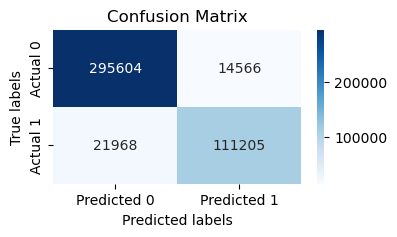

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94    310170
           1       0.88      0.84      0.86    133173

    accuracy                           0.92    443343
   macro avg       0.91      0.89      0.90    443343
weighted avg       0.92      0.92      0.92    443343

Time:  15.9


In [41]:
cm = confusion_matrix(y_test, predictions)

# Display confusion matrix as a heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
# Generate classification report
report = classification_report(y_test, predictions)
# Print the classification report
print("Classification Report:\n", report)
print('Time: ', round(time.time()-t1)/60)

### SHAP

In [ ]:
import shap
explainer = shap.Explainer(model_30)
shap_values = explainer(X_test)

# Visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# For a summary plot for all features across all test data
shap.summary_plot(shap_values, X_test)

### 60 Days

In [42]:
t1= time.time()

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y_60, test_size=0.2, random_state=42)

In [43]:
# Initialize the Random Forest Classifier
model_60 = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Train the model
model_60.fit(X_train, y_train)

# Predict on the test set
predictions = model_60.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Print the classification report
report = classification_report(y_test, predictions)
print("Classification Report:\n", report)

print('Time: ', round(time.time()-t1)/60)

Accuracy: 0.9008645676146911
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91    250979
           1       0.89      0.88      0.88    192364

    accuracy                           0.90    443343
   macro avg       0.90      0.90      0.90    443343
weighted avg       0.90      0.90      0.90    443343

Time:  47.9


### 365 Days

In [44]:
t1= time.time()

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y_365, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
model_365 = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Train the model
model_365.fit(X_train, y_train)

# Predict on the test set
predictions = model_365.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Print the classification report
report = classification_report(y_test, predictions)
print("Classification Report:\n", report)

print('Time: ', round(time.time()-t1)/60)

Accuracy: 0.9245820955783671
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95    321034
           1       0.89      0.83      0.86    122309

    accuracy                           0.92    443343
   macro avg       0.91      0.90      0.90    443343
weighted avg       0.92      0.92      0.92    443343

Time:  41.333333333333336


## Convert to Pickle

In [45]:
# Save the dictionary containing all models into a single file using pickle
with open('Models/model_30.pkl', 'wb') as file:
    pickle.dump(model_30, file)

In [46]:
# Save the dictionary containing all models into a single file using pickle
with open('Models/model_60.pkl', 'wb') as file:
    pickle.dump(model_60, file)

In [47]:
# Save the dictionary containing all models into a single file using pickle
with open('Models/model_365.pkl', 'wb') as file:
    pickle.dump(model_365, file)

In [50]:
# Create a dictionary to store all the models
models_dict = {
    '30_days': model_30,
    '60_days': model_60,
    '365_days': model_365
}

# Save the dictionary containing all models into a single file using pickle
with open('Models/readmission_model.pkl', 'wb') as file:
    pickle.dump(models_dict, file)

OSError: [Errno 28] No space left on device

## SHAP

# EDA
- [Load Data](#Load-Data)
- [Chart Events](#Chart-Events)
- [Rules](#Rules)

## Admission Type

***Most of the Admission Types are from Emergency Department***

In [ ]:
# Calculate percentages for both columns
admission_type_percentages = admin_diag['admission_type'].value_counts(normalize=True) * 100
admission_location_percentages = admin_diag['admission_location'].value_counts(normalize=True) * 100

plt.figure(figsize=(14, 6))

# Subplot for admission_type
plt.subplot(1, 2, 1)
plt.title('Percentage of Admission Types')
ax1 = admin_diag['admission_type'].value_counts().plot(kind='bar')
for i, v in enumerate(admission_type_percentages):
    ax1.text(i, admin_diag['admission_type'].value_counts()[i] + 1, f'{v:.0f}%', ha='center', va='bottom')

# Subplot for admission_location
plt.subplot(1, 2, 2)
plt.title('Percentage of Admission Locations')
ax2 = admin_diag['admission_location'].value_counts().plot(kind='bar')
for i, v in enumerate(admission_location_percentages):
    ax2.text(i, admin_diag['admission_location'].value_counts()[i] + 1, f'{v:.0f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Discharge Location
***Most Discharge are from Home***
 - Top 5 Discharge are considered

In [ ]:
percentages = admin_diag['discharge_location'].value_counts(normalize=True) * 100

plt.figure(figsize=(4, 4))
ax = admin_diag['discharge_location'].value_counts().head().plot(kind='bar')

for i, v in enumerate(admin_diag['discharge_location'].value_counts().head()):
    ax.text(i, v + 1, f'{percentages[i]:.0f}%', ha='center', va='bottom')

plt.show()

In [ ]:
percentages = admin_diag['insurance'].value_counts(normalize=True) * 100

plt.figure(figsize=(4, 4))
ax = admin_diag['insurance'].value_counts().plot(kind='bar')

for i, v in enumerate(admin_diag['insurance'].value_counts()):
    ax.text(i, v + 1, f'{percentages[i]:.0f}%', ha='center', va='bottom')

plt.show()

In [ ]:
# Calculate percentages
percentages = admin_diag['marital_status'].value_counts(normalize=True) * 100

plt.figure(figsize=(5, 2))
ax = percentages.plot(kind='bar')
ax.set_ylabel('Percentage')

for i, v in enumerate(percentages):
    ax.text(i, v - 5, f'{v:.0f}%', ha='center', va='bottom', color='white')  # Percentage inside the bar

plt.show()

## Race
***Getting the top 10 Races***
 - White and African-American are the highest admitted patients

In [ ]:
plt.figure(figsize=(12, 2))
df=admin_diag['race'].value_counts(normalize=True).head(10)*100
ax = df.plot(kind='bar')
for i, v in enumerate(df):
    ax.text(i, v + 5, f'{v:.0f}%', ha='center', va='bottom', color='black')

plt.show()


In [ ]:
admin_diag.head(1)

In [ ]:
plt.figure(figsize=(10, 2))
admin_diag['long_title'].value_counts(normalize=True).head(20)*100#.plot(kind='bar')


In [ ]:
admin_diag['long_title'].nunique()

In [ ]:
admin_diag.info()

In [ ]:
admin_diag['long_title'].nunique()

In [ ]:
admin_diag_encoded.admission_type.value_counts()

In [ ]:
## Item Id Chart events Aggregation

In [ ]:
import pandas as pd

# # Your DataFrame
# data = {
#     'subject_id': [19999987, 19999987, 19999987],
#     'hadm_id': [23865745, 23865745, 23865745],
#     'stay_id': [36195440, 36195440, 36195440],
#     'charttime': [
#         '2145-11-04 21:01:00.000000 UTC',
#         '2145-11-04 21:01:00.000000 UTC',
#         '2145-11-04 21:01:00.000000 UTC'
#     ],
#     'itemid': [220179, 220181, 220180],
#     'value': [143, 116, 107],
#     'valuenum': [143, 116, 107],
#     'valueuom': ['mmHg', 'mmHg', 'mmHg']
# }

# df = pd.DataFrame(data)

# Group by 'valueuom' and check if there's more than one unique value
grouped = df.groupby('valueuom')
if len(grouped) > 1:
    # If there are multiple unique 'valueuom', explode rows for each 'itemid'
    result = df.assign(itemid=df['itemid'].astype(str)).explode('itemid')
else:
    # If 'valueuom' is the same for all rows, take the mean of 'value' and create a column with the first 'itemid' name
    result = df.groupby('valueuom').agg({
        'subject_id': 'first',
        'hadm_id': 'first',
        'stay_id': 'first',
        'charttime': 'first',
        'value': 'mean', 
        'valuenum': 'mean', 
        'itemid': lambda x: x.iloc[0]
    }).reset_index()

display(result)
